In [31]:
from skimage import io, transform, color
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image
import os

from dataLoader import OrganoidDataset
#from conv_model import SimpleConvNet
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# global variables

In [32]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

In [33]:
figure_path = '../milestoneReport/figures/'
path = '../data/CS231n_Tim_Shan_example_data/'
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

# load data

In [34]:
label = pd.read_csv(label_path)
new_columns = ['well_id','day','median_pixel_intensity','mw_area_shape','hyst1_area','hyst2_area']
label.columns = new_columns

In [35]:
def get_image_name(well_id,day_id):
    image_name = 'well'+str(well_id).zfill(4)+'_day'+str(day_id).zfill(2)+'_well.png'
    return image_name
def get_well_label(well_id):
    return str(well_id).zfill(4)

In [36]:
label['image_name'] = label[['well_id','day']].apply(lambda x: get_image_name(*x),axis=1)
label['well_label'] = label['well_id'].apply(lambda x: get_well_label(x))

In [37]:
label.head(2)

,well_id,day,median_pixel_intensity,mw_area_shape,hyst1_area,hyst2_area,image_name,well_label
0,0,0,125.0,7830,512,418,well0000_day00_well.png,0000
1,1,0,125.0,8265,3044,3008,well0001_day00_well.png,0001


In [38]:
corrected_labels = label.query("mw_area_shape < 32000")

In [39]:
corrected_labels.loc[:,'has_cell'] = np.int64(corrected_labels['hyst2_area'] > 0)

In [40]:
def get_day_description(corrected_labels,day):
    df = corrected_labels.query("day == %d"%day)[['well_id','day','well_label','image_name','has_cell']]
    day_suffix = '_' + str(day)
    df = df.rename(columns={'day':'day'+day_suffix, 'has_cell':'has_cell'+day_suffix,'image_name':'image_name'+day_suffix})
    return df

In [41]:
day2wells = get_day_description(corrected_labels,2)
day8wells = get_day_description(corrected_labels,8)
day13wells = get_day_description(corrected_labels,13)

In [42]:
day2wells.shape, day8wells.shape, day13wells.shape

((4712, 5), (4642, 5), (4712, 5))

In [43]:
merged_days = day2wells.merge(day8wells,on=['well_id','well_label']).merge(day13wells,on=['well_id','well_label'])

In [44]:
merged_days.shape

(4510, 11)

In [45]:
#shuffle dataframe
merged_days = merged_days.sample(frac=1).reset_index(drop=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f627a5d27f0>,
      dtype=object)

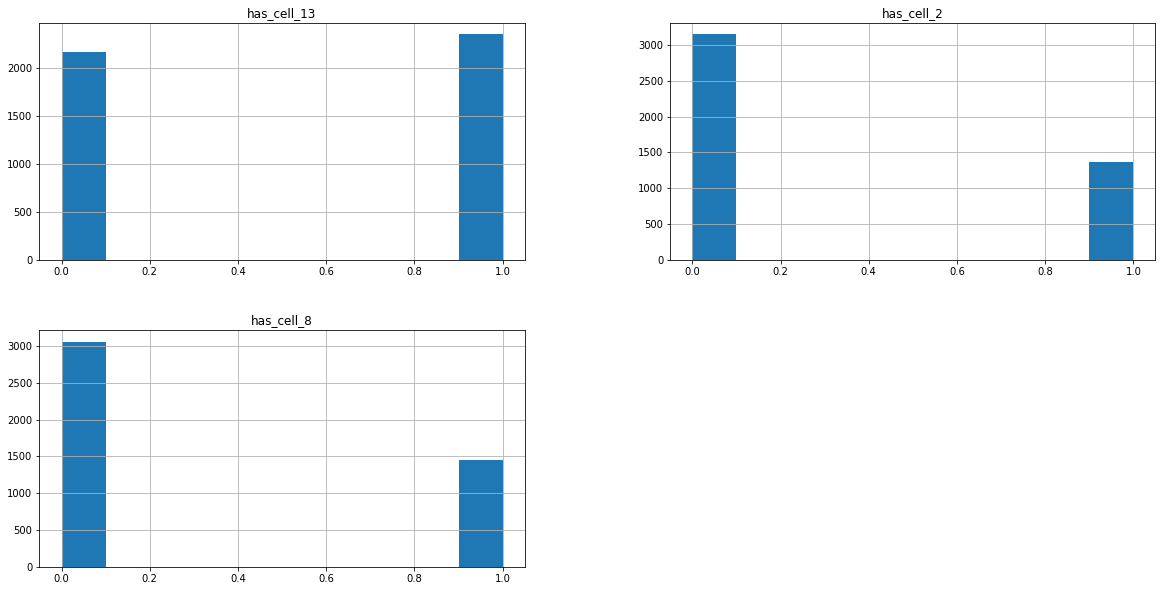

In [46]:
merged_days[['has_cell_2','has_cell_8','has_cell_13']].hist()

In [16]:
merged_days.head(2)

,well_id,day_1,well_label,image_name_1,has_cell_1,day_8,image_name_8,has_cell_8,day_13,image_name_13,has_cell_13
0,2725,1,2725,well2725_day01_well.png,0,8,well2725_day08_well.png,0,13,well2725_day13_well.png,0
1,3913,1,3913,well3913_day01_well.png,1,8,well3913_day08_well.png,0,13,well3913_day13_well.png,0


### test image

In [40]:
image_name = 'well1705_day01_well.png'

In [60]:
image = imread(path+image_name)

In [61]:
image

Array([[[139, 139, 139, 255],
        [134, 134, 134, 255],
        [130, 130, 130, 255],
        ...,
        [134, 134, 134, 255],
        [135, 135, 135, 255],
        [128, 128, 128, 255]],

       [[134, 134, 134, 255],
        [131, 131, 131, 255],
        [131, 131, 131, 255],
        ...,
        [134, 134, 134, 255],
        [134, 134, 134, 255],
        [130, 130, 130, 255]],

       [[131, 131, 131, 255],
        [131, 131, 131, 255],
        [131, 131, 131, 255],
        ...,
        [131, 131, 131, 255],
        [131, 131, 131, 255],
        [130, 130, 130, 255]],

       ...,

       [[127, 127, 127, 255],
        [128, 128, 128, 255],
        [128, 128, 128, 255],
        ...,
        [131, 131, 131, 255],
        [130, 130, 130, 255],
        [128, 128, 128, 255]],

       [[127, 127, 127, 255],
        [128, 128, 128, 255],
        [130, 130, 130, 255],
        ...,
        [130, 130, 130, 255],
        [128, 128, 128, 255],
        [128, 128, 128, 255]],

       [[128

In [48]:
image.shape

(193, 193, 4)

In [50]:
color.rgb2gray(image)

array([[0.54509804, 0.5254902 , 0.50980392, ..., 0.5254902 , 0.52941176,
        0.50196078],
       [0.5254902 , 0.51372549, 0.51372549, ..., 0.5254902 , 0.5254902 ,
        0.50980392],
       [0.51372549, 0.51372549, 0.51372549, ..., 0.51372549, 0.51372549,
        0.50980392],
       ...,
       [0.49803922, 0.50196078, 0.50196078, ..., 0.51372549, 0.50980392,
        0.50196078],
       [0.49803922, 0.50196078, 0.50980392, ..., 0.50980392, 0.50196078,
        0.50196078],
       [0.50196078, 0.50196078, 0.50196078, ..., 0.50980392, 0.50980392,
        0.50980392]])

In [51]:
day1_mean_and_var = pd.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

In [52]:
day1_mean_and_var

,mean,variance
0,0.504038,0.026985


In [63]:
image = color.rgb2gray(image)

In [64]:
image.shape

(193, 193)

In [65]:
image2 = image.copy()

In [ ]:
np.concatenate

In [56]:
image = np.reshape(image, newshape = (1, image.shape[0], image.shape[1]))

In [57]:
image.shape

(1, 193, 193)

In [58]:
torch_image = torch.from_numpy(image).float()

In [66]:
torch_image

tensor([[[0.5451, 0.5255, 0.5098,  ..., 0.5255, 0.5294, 0.5020],
         [0.5255, 0.5137, 0.5137,  ..., 0.5255, 0.5255, 0.5098],
         [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5137, 0.5098],
         ...,
         [0.4980, 0.5020, 0.5020,  ..., 0.5137, 0.5098, 0.5020],
         [0.4980, 0.5020, 0.5098,  ..., 0.5098, 0.5020, 0.5020],
         [0.5020, 0.5020, 0.5020,  ..., 0.5098, 0.5098, 0.5098]]])

In [74]:
np.concatenate((image,image2),axis=0).shape

(386, 193)

In [76]:
np.array([image,image2]).shape

(2, 193, 193)

In [79]:
image_names = {1:merged_days['image_name_1'],8:merged_days['image_name_8']}

In [80]:
mean_sd_dict={1:[0.5,0.02],8:[0.5,0.02]}

In [81]:
index = 0

In [84]:
np.array([]).append(image)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [96]:
    all_images_list = []
    for day,img_names in image_names.items():
        img_name = img_names[index]
        img_loc = os.path.join(path, img_name)
        image = io.imread(img_loc)
        mean, sd = mean_sd_dict[day]
        image = np.true_divide(color.rgb2gray(image) - mean, sd)
        all_images_list.append(image)
    images = np.array(all_images_list)

In [97]:
images

array([[[ 2.25490196,  1.2745098 ,  0.49019608, ...,  1.2745098 ,
          1.47058824,  0.09803922],
        [ 1.2745098 ,  0.68627451,  0.68627451, ...,  1.2745098 ,
          1.2745098 ,  0.49019608],
        [ 0.68627451,  0.68627451,  0.68627451, ...,  0.68627451,
          0.68627451,  0.49019608],
        ...,
        [-0.09803922,  0.09803922,  0.09803922, ...,  0.68627451,
          0.49019608,  0.09803922],
        [-0.09803922,  0.09803922,  0.49019608, ...,  0.49019608,
          0.09803922,  0.09803922],
        [ 0.09803922,  0.09803922,  0.09803922, ...,  0.49019608,
          0.49019608,  0.49019608]],

       [[ 2.25490196,  1.8627451 ,  2.25490196, ...,  1.07843137,
          1.07843137,  0.29411765],
        [ 2.25490196,  1.47058824,  0.68627451, ...,  1.07843137,
          1.07843137,  1.07843137],
        [ 0.09803922,  0.29411765,  0.09803922, ...,  0.68627451,
          0.68627451,  1.47058824],
        ...,
        [ 1.07843137,  0.29411765,  0.29411765, ...,  

In [95]:
np.array(all_images).shape

(2, 193, 193)

## normalization

In [47]:
def update_mean(x, x_bar_prev, n):
  return x_bar_prev + (x - x_bar_prev)/n

def update_sum_square_diff(x, ssd_prev, x_bar_prev, x_bar_curr):
  return ssd_prev + (x - x_bar_prev)*(x - x_bar_curr)

In [48]:
def get_mean_std(image_names):
    #image_names = merged_days['image_name_1']
    x_bar_curr = 0.0
    x_bar_prev = 0.0
    ssd_curr = 0.0
    n = 0
    for index in range(len(image_names)):
        img_name = image_names[index]
        img_loc = os.path.join(path, img_name)
      # skimage.io.imread returns a numpy array
        image = io.imread(img_loc)
      # convert to grey scale
        image = color.rgb2gray(image)
        for i, x in np.ndenumerate(image):
            n = n + 1
            x_bar_prev = x_bar_curr
            x_bar_curr = update_mean(x, x_bar_prev, n)
            ssd_curr = update_sum_square_diff(x, ssd_curr, x_bar_prev, x_bar_curr)
    return x_bar_curr, ssd_curr/n

In [25]:
day1_std = ssd_curr/n

0.026858544900843943

In [26]:
day1_mean = x_bar_curr

0.5030599878198688

In [30]:
mean_sd_dict = {}

In [50]:
#mean_sd_dict[1] = [day1_mean, day1_std]

In [51]:
day8_mean, day8_std = get_mean_std(merged_days['image_name_8'])
day2_mean, day2_std = get_mean_std(merged_days['image_name_2'])

In [80]:
mean_sd_dict[2] = [day2_mean, np.sqrt(day2_std)]
mean_sd_dict[8] = [day8_mean, np.sqrt(day8_std)]

In [81]:
mean_sd_dict

{2: [0.49286571111372995, 0.16116063273637155],
 8: [0.5374226001116033, 0.15356177002318155]}

In [82]:
mean_sd_df = pd.DataFrame.from_dict(mean_sd_dict,orient='index',columns=['mean','std'])

In [83]:
mean_sd_df.to_csv("mean_sd_for_4510images.csv")

## data loader

In [85]:
class OrganoidMultipleDataset(data.Dataset):
    'dataset class for microwell organoid images'
    def __init__(self, path2files, image_names, Y, mean_sd_dict):
        for k, image_name in image_names.items():
            assert len(image_name) == len(Y)
        self.path = path2files
        self.image_names = image_names
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def getXimage(self, index):
        all_images_list = []
        for day,img_names in self.image_names.items():
            img_name = img_names[index]
            img_loc = os.path.join(self.path, img_name)
            image = io.imread(img_loc)
            mean, sd = self.mean_sd_dict[day]
            image = np.true_divide(color.rgb2gray(image) - mean, sd)
            all_images_list.append(image)
        images = np.array(all_images_list)
        return torch.from_numpy(images).float()
    def getY(self, index):
        Y = self.Y[index]
        return torch.from_numpy(np.asarray(self.Y[index], dtype=float)).float()
    def __getitem__(self, index):
        X = self.getXimage(index)
        y = self.getY(index)
        return X, y

In [86]:
training_labels=merged_days[:100]
validation_labels = merged_days[100:200]

In [87]:
training_image_names = {2:training_labels['image_name_2'],8:training_labels['image_name_8']}
validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8']}
training_y = training_labels['has_cell_13']
validation_y = training_labels['has_cell_13']


In [88]:
train_set = OrganoidMultipleDataset(path2files = path, image_names = training_image_names, Y = training_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)
validation_set = OrganoidMultipleDataset(path2files = path, image_names = validation_image_names, Y = validation_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)


In [90]:
training_generator = data.DataLoader(train_set, **params)
validation_generator = data.DataLoader(validation_set, **params)

# Model

In [91]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [92]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [94]:
print("yes")

yes


In [95]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [ ]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()